In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import requests

In [4]:
## Cargar fuente Pricestats

pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv')

cpi = pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv').dropna(subset = ['index'])
# cpi.index = pd.date_range("1943-01", periods=len(cpi), freq = 'M')
cpi.index = pd.date_range("1942-12", periods=len(cpi), freq = 'M') + pd.DateOffset(days=15)

## Cargar fuente Indec para IPC post 2015
### Descargar info actualizada en ipc_b201612_mensual.csv
csv_url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv'
req = requests.get(csv_url)
csv_file = open('./../data/info/ipc_b201612_mensual.csv', 'wb')
csv_file.write(req.content)
csv_file.close()

## Usar archivo
cpi2 = pd.read_csv('./../data/info/ipc_b201612_mensual.csv',
                   usecols = ['ipc_ng_nacional']).astype(float)
# cpi2.index = pd.date_range("2016-12", periods=len(cpi2), freq = 'M')
cpi2.index = pd.date_range("2016-11", periods=len(cpi2), freq = 'M') + pd.DateOffset(days=15)

cpi2.columns = ['index']

### Graficar el empalme de indices

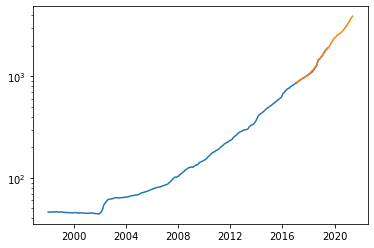

In [3]:
m = np.mean(cpi.loc['2017':]['index'].values/cpi2.loc['2017':]['index'].values[:len(cpi.loc['2017':])])

plt.plot(cpi.loc['1998':][['index']])
plt.plot(m*cpi2.loc['2017':][['index']])

plt.yscale('log')
plt.show()

In [4]:
## Si esta todo ok se pueden unir
cpi = pd.concat([cpi.loc[:cpi2.index.values[0]][['index']],
           m*cpi2.iloc[1:]], )

In [5]:
cpi.tail()

,index
2021-01-15,3363.379502
2021-02-15,3483.607931
2021-03-15,3651.197603
2021-04-15,3800.177183
2021-05-15,3926.456237


In [6]:
## Tasa de inflacion de los ultimos 12 meses. Se usa para completar la inflacion del ultimo mes antes que se mida.
r = cpi.pct_change().tail(6).mean()[0]
print(r)

## Estirar la serie de CPI hasta el dia de hoy (para precios actualizados)
meses_presente = pd.date_range(cpi.index[-1], 
              pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)

cpi = pd.concat([cpi, pd.DataFrame([], index = meses_presente)])

last_valid_ix = cpi.dropna().iloc[-1] # Level of the cpi index in last valid month

cpi['avg_rate'] = pd.Series((1 + r)**range(len(cpi)), index = cpi.index)  ## Compute the exponential curve

# Bring to actual level
ratio = cpi.loc[last_valid_ix.name].avg_rate / cpi.loc[last_valid_ix.name]['index'] 
cpi['avg_rate'] = cpi['avg_rate']/ratio  

# Complete cpi series up to present and remove exponential
cpi['index'] = cpi['index'].fillna(cpi['avg_rate'])
cpi = cpi.drop('avg_rate', axis = 1)

nivel_precios_actual = cpi.tail(1)['index']
display(nivel_precios_actual)

0.03973884591590896


<ipython-input-6-e11a8e0a56ab>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)


2022-02-15    5575.954122
Name: index, dtype: float64

In [7]:
cpi.to_csv('./../data/info/indice_precios_M.csv')
cpi.tail()

,index
2021-10-15,4771.139465
2021-11-15,4960.739041
2021-12-15,5157.873085
2022-01-15,5362.841009
2022-02-15,5575.954122


In [8]:
### Ver de ponerle el valor a mitad de mes.

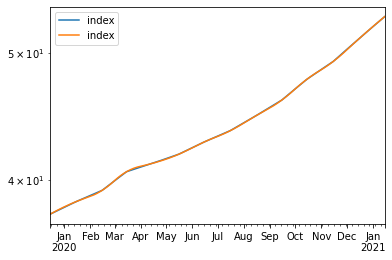

In [9]:
pd.options.display.max_rows = 99
## Interpolado a frecuencia diaria (util para llevar al "dia de hoy")

fig, ax = plt.subplots()
(cpi/cpi.loc['2003-01-15']).reindex(pd.date_range(
    start = '2019-12-15', end = '2021-01-15', freq = 'd')).interpolate(method = 'time').plot(ax = ax)
(cpi/cpi.loc['2003-01-15']).reindex(pd.date_range(
    start = '2019-12-15', end = '2021-01-15', freq = 'd')).interpolate(method = 'quadratic').plot(ax = ax)
ax.set_yscale('log')

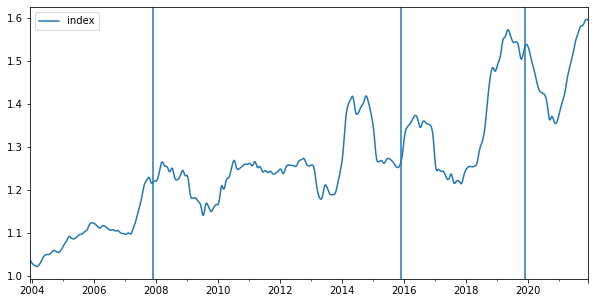

In [10]:
cpi_d = cpi.reindex(pd.date_range(
    start = '2002-12-15', end = '2021-12-15', freq = 'd')).interpolate(method = 'quadratic')
fig, ax = plt.subplots(1, figsize = (10, 5))
(cpi_d/cpi_d.shift(365)).dropna().plot(ax = ax)
ax.axvline('2007-12')
ax.axvline('2015-12')
ax.axvline('2019-12')

In [11]:
# index_d = (cpi_d/cpi_d.loc['2016-01-01']).dropna()
index_d = cpi_d.dropna()
index_d.to_csv('./../data/info/indice_precios_d.csv')

In [12]:
# display(index_d.loc[index_d['index'] >= .1].iloc[[0]])
# display(index_d.loc[index_d['index'] >= .2].iloc[[0]])
# display(index_d.loc[index_d['index'] >= .5].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 1].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 2].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 5].iloc[[0]])

In [13]:
(index_d/index_d.shift(365)).iloc[-365*5:].mean()

index    1.406459
dtype: float64

In [14]:
100*cpi.tail(15).pct_change().round(4)

,index
2020-12-15,NaN
2021-01-15,4.05
2021-02-15,3.57
2021-03-15,4.81
2021-04-15,4.08
2021-05-15,3.32
2021-06-15,3.97
2021-07-15,3.97
2021-08-15,3.97
2021-09-15,3.97


In [15]:
cpi_ = cpi.groupby(pd.Grouper(freq='Q')).mean().loc['2003':][['index']]#.to_csv(...)

### Convenciones para fijar fecha de cuatrimestre.
cpi_.index = cpi_.index - pd.to_timedelta(cpi_.index.day - 15, unit='d') - pd.DateOffset(months=1)
cpi_.index.name = 'Q'

cpi_.tail()

,index
Q,
2021-02-15,3499.395012
2021-05-15,3936.374165
2021-08-15,4415.637241
2021-11-15,4963.250530
2022-02-15,5469.397565


In [16]:
from datetime import datetime

In [17]:
cpi_.to_csv('./../data/info/indice_precios_Q.csv')

In [18]:
# cpi = cpi.groupby(pd.Grouper(freq='Q')).mean().loc[str(startyr):str(endyr)][['index']]#.to_csv(...)
# cpi.set_index('index')
# cpi.index.name = 'Q'
# #
# indice_precios = cpi

## Tipo de Cambio

In [29]:
## Cargar fuente Indec para IPC post 2015
### Descargar info actualizada en ipc_b201612_mensual.csv
# csv_url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv'
csv_url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/168/distribution/168.1/download/datos-tipo-cambio-usd-futuro-dolar-frecuencia-diaria.csv'
req = requests.get(csv_url)
csv_file = open('./../data/info/tcambiousd_diario.csv', 'wb')
csv_file.write(req.content)
csv_file.close()


## Usar archivo
usd = pd.read_csv('./../data/info/tcambiousd_diario.csv',
                 usecols = ['indice_tiempo','tipo_cambio_a3500']
                 ).set_index('indice_tiempo').astype(float)

usd.index = pd.to_datetime(usd.index, format='%Y-%m-%d')
usd = usd.loc['2003':]
usd = usd.groupby(pd.Grouper(level = 0, freq = 'M')).mean()
usd.index = usd.index + pd.offsets.MonthEnd(-1) + pd.offsets.Day(15)
usd.tail()

,tipo_cambio_a3500
indice_tiempo,
2021-01-15,85.845861
2021-02-15,88.723921
2021-03-15,91.095058
2021-04-15,92.729677
2021-05-15,94.099952


In [30]:
## Tasa de inflacion de los ultimos 12 meses. Se usa para completar la inflacion del ultimo mes antes que se mida.
r = usd.pct_change().tail(6).mean()[0]
print(r)

## Estirar la serie de CPI hasta el dia de hoy (para precios actualizados)
meses_presente = pd.date_range(usd.index[-1], 
              pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)

usd = pd.concat([usd, pd.DataFrame([], index = meses_presente)])

last_valid_ix = usd.dropna().iloc[-1] # Level of the cpi index in last valid month

usd['avg_rate'] = pd.Series((1 + r)**range(len(usd)), index = usd.index)  ## Compute the exponential curve

# Bring to actual level
ratio = usd.loc[last_valid_ix.name].avg_rate / usd.loc[last_valid_ix.name]['tipo_cambio_a3500'] 
usd['avg_rate'] = usd['avg_rate']/ratio  

# Complete cpi series up to present and remove exponential
usd['tipo_cambio_a3500'] = usd['tipo_cambio_a3500'].fillna(usd['avg_rate'])
usd = usd.drop('avg_rate', axis = 1)


0.027680096840586515


<ipython-input-30-2afa7c65227c>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)


<AxesSubplot:>

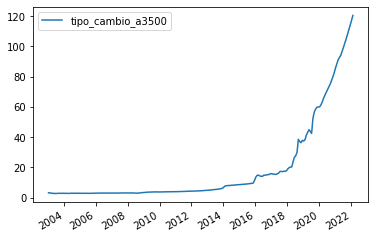

In [31]:
# usd.rolling(30).mean().plot() #legend = False
usd.plot() #legend = False

In [32]:
usd = usd.groupby(pd.Grouper(level = 0, freq = 'Q')).mean()
usd.index = usd.index + pd.offsets.MonthEnd(-2) + pd.offsets.Day(15)
usd.index.name = 'Q'
usd.tail()

,tipo_cambio_a3500
Q,
2021-02-15,88.554947
2021-05-15,94.511425
2021-08-15,102.157711
2021-11-15,110.877899
2022-02-15,118.692262


In [33]:
usd.to_csv('./../data/info/ARS_USD_Q.csv')

## Poder de Compra (PPP)

In [5]:
csv_url = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.PPP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en'
req = requests.get(csv_url)
csv_file = open('./../data/info/ex_PPP.csv', 'wb')
csv_file.write(req.content)
csv_file.close()

## Usar archivo
ppp = pd.read_csv('./../data/info/ex_PPP.csv')
ppp = ppp.loc[ppp.LOCATION == 'ARG'][['TIME', 'Value']].set_index('TIME').astype(float)


ppp.index = pd.to_datetime(ppp.index, format='%Y')
ppp = ppp.loc['2003':]
# ppp = ppp.groupby(pd.Grouper(level = 0, freq = 'M')).mean()
ppp.index = ppp.index + pd.DateOffset(months=6)
ppp.tail()

,Value
TIME,
2016-07-01,9.294966
2017-07-01,10.256822
2018-07-01,14.024082
2019-07-01,20.752961
2020-07-01,28.673797


In [6]:
## Tasa de inflacion de los ultimos 12 meses. Se usa para completar la inflacion del ultimo mes antes que se mida.
tseries = ppp
r = tseries.pct_change().tail(6).mean()[0]
print(r)

## Estirar la serie de CPI hasta el dia de hoy (para precios actualizados)
cur_end = tseries.index[-1]
new_end = tseries.index[-1] + pd.DateOffset(years = 2)
anos_presente = pd.date_range(cur_end, new_end, freq = 'Y') + pd.DateOffset(months = 6, days = 1)

tseries = pd.concat([tseries, pd.DataFrame([], index = anos_presente)])

last_valid_ix = tseries.dropna().iloc[-1] # Level of the cpi index in last valid month

tseries['avg_rate'] = pd.Series((1 + r)**range(len(tseries)), index = tseries.index)  ## Compute the exponential curve

# Bring to actual level
ratio = tseries.loc[last_valid_ix.name].avg_rate / tseries.loc[last_valid_ix.name]['Value'] 
tseries['avg_rate'] = tseries['avg_rate']/ratio  

# Complete cpi series up to present and remove exponential
tseries['Value'] = tseries['Value'].fillna(tseries['avg_rate'])
tseries = tseries.drop('avg_rate', axis = 1)

ppp = tseries
ppp.tail()

0.32422972585025006


,Value
2018-07-01,14.024082
2019-07-01,20.752961
2020-07-01,28.673797
2021-07-01,37.970694
2022-07-01,50.281922


In [7]:
# # ## Conversor PPP
# # PA.NUS.PPP
# # PPP conversion factor, GDP (LCU per international $)
# # Purchasing power parity (PPP) conversion factor is a spatial price deflator and currency converter 
# # that controls for price level differences between countries, thereby allowing volume comparisons of
# # gross domestic product (GDP) and its expenditure components. This conversion factor is for GDP.	
# # International Comparison Program, World Bank | World Development Indicators database, World Bank | 
# # Eurostat-OECD PPP Programme.

    
# csv_url = 'https://api.worldbank.org/v2/en/indicator/PA.NUS.PPP?downloadformat=csv'
# req = requests.get(csv_url)
# csv_file = open('./../data/info/PA_PPP.zip', 'wb')
# csv_file.write(req.content)
# csv_file.close()

# import zipfile
# zf = zipfile.ZipFile('./../data/info/PA_PPP.zip', 'r')
# ppp = pd.read_csv(zf.open('API_PA.NUS.PPP_DS2_en_csv_v2_2708557.csv'), skiprows = 4, index_col=[0, 1, 2, 3])
# ppp = ppp.loc['Argentina'].T.dropna().pct_change()
# ppp.columns = ['ARG_PA_PPP']

# ## Extend to current times
# mn_ppp = ppp.tail(3).mean()
# _2021 = pd.DataFrame(mn_ppp, columns = ['2021'], index = ['ARG_PA_PPP']).T
# _2022 = pd.DataFrame(mn_ppp, columns = ['2022'], index = ['ARG_PA_PPP']).T
# ppp = ppp.append(_2021).append(_2022)

# ppp.index = pd.to_datetime(ppp.index)
# ppp.index = ppp.index + pd.DateOffset(months=6)# + pd.offsets.MonthEnd(-1) + pd.offsets.Day(15)
# ppp.index.name = 'Q'

# ppp.tail()

In [8]:
ppp = ppp.resample('d').mean().interpolate(method = 'quadratic')#.plot()
ppp = ppp.loc['2003':]
ppp = ppp.groupby(pd.Grouper(level = 0, freq = 'M')).mean()
ppp.index = ppp.index + pd.offsets.MonthEnd(-1) + pd.offsets.Day(15)
ppp.tail()

,Value
2022-03-15,46.334365
2022-04-15,47.431127
2022-05-15,48.550894
2022-06-15,49.693417
2022-07-15,50.281922


In [9]:
ppp = ppp.groupby(pd.Grouper(level = 0, freq = 'Q')).mean()
ppp.index = ppp.index + pd.offsets.MonthEnd(-2) + pd.offsets.Day(15)
ppp.index.name = 'Q'
ppp.tail()

,Value
Q,
2021-08-15,39.345440
2021-11-15,42.232381
2022-02-15,45.302343
2022-05-15,48.558479
2022-08-15,50.281922


<AxesSubplot:xlabel='Q'>

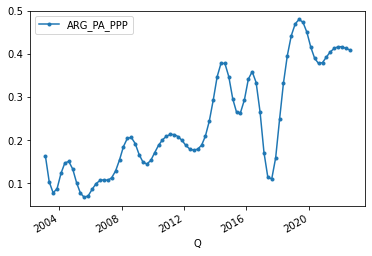

In [25]:
ppp.plot(marker = '.')

In [10]:
ppp.to_csv('./../data/info/ARG_PPP_Q.csv')